In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import scarches
from scarches.dataset import remove_sparsity
from lataq.models import EMBEDCVAE, TRANVAE

sc.settings.set_figure_params(dpi=600, frameon=False)
sc.set_figure_params(dpi=600)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

def set_axis_style(ax, labels):
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')
    
%load_ext autoreload
%autoreload 2

Global seed set to 0


# Create reference data without Delta cells and query data with Delta cells

In [2]:
adata = sc.read(
    f'../data/pancreas.h5ad'
)
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [3]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [4]:
condition_key = "study"
cell_type_keys = ["cell_type"]
remove_cts = ["beta"]
reference = ["inDrop1", 
             "inDrop2", 
             "inDrop3", 
             "inDrop4", 
             "fluidigmc1", 
             "smartseq2", 
             "smarter"]
query = ["celseq", 
         "celseq2"]

In [5]:
palette_ct = {
    'acinar': '#1f77b4',
    'activated_stellate': '#ff7f0e',
    'alpha': '#279e68',
    'delta': '#d62728',
    'ductal': '#aa40fc',
    'endothelial': '#8c564b',
    'epsilon':'#e377c2',
    'gamma': '#b5bd61',
    'macrophage': '#17becf',
    'mast': '#aec7e8',
    'quiescent_stellate': '#ffbb78',
    'schwann': '#98df8a',
    't_cell': '#ff9896',
    'unknown': '#c5b0d5'
}

palette_study = {
    'fluidigmc1': '#1f77b4',
    'inDrop1': '#ff7f0e',
    'inDrop2': '#279e68',
    'inDrop3': '#d62728',
    'inDrop4': '#aa40fc',
    'smarter': '#8c564b',
    'smartseq2': '#e377c2',
    'celseq': '#b5bd61',
    'celseq2': '#17becf'
}

In [6]:
cell_type_key = cell_type_keys[-1]
adata = remove_sparsity(adata)
ref_adata = adata[adata.obs.study.isin(reference)].copy()
ref_adata = ref_adata[~ref_adata.obs.cell_type.isin(remove_cts)].copy()
query_adata = adata[adata.obs.study.isin(query)].copy()
adata = ref_adata.concatenate(query_adata)
adata.obs['query'] = adata.obs.study.isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [7]:
adata_plot = ref_adata.copy()
sc.pp.normalize_total(adata_plot)
sc.pp.log1p(adata_plot)
sc.pp.pca(adata_plot)
sc.pp.neighbors(adata_plot)
sc.tl.umap(adata_plot)

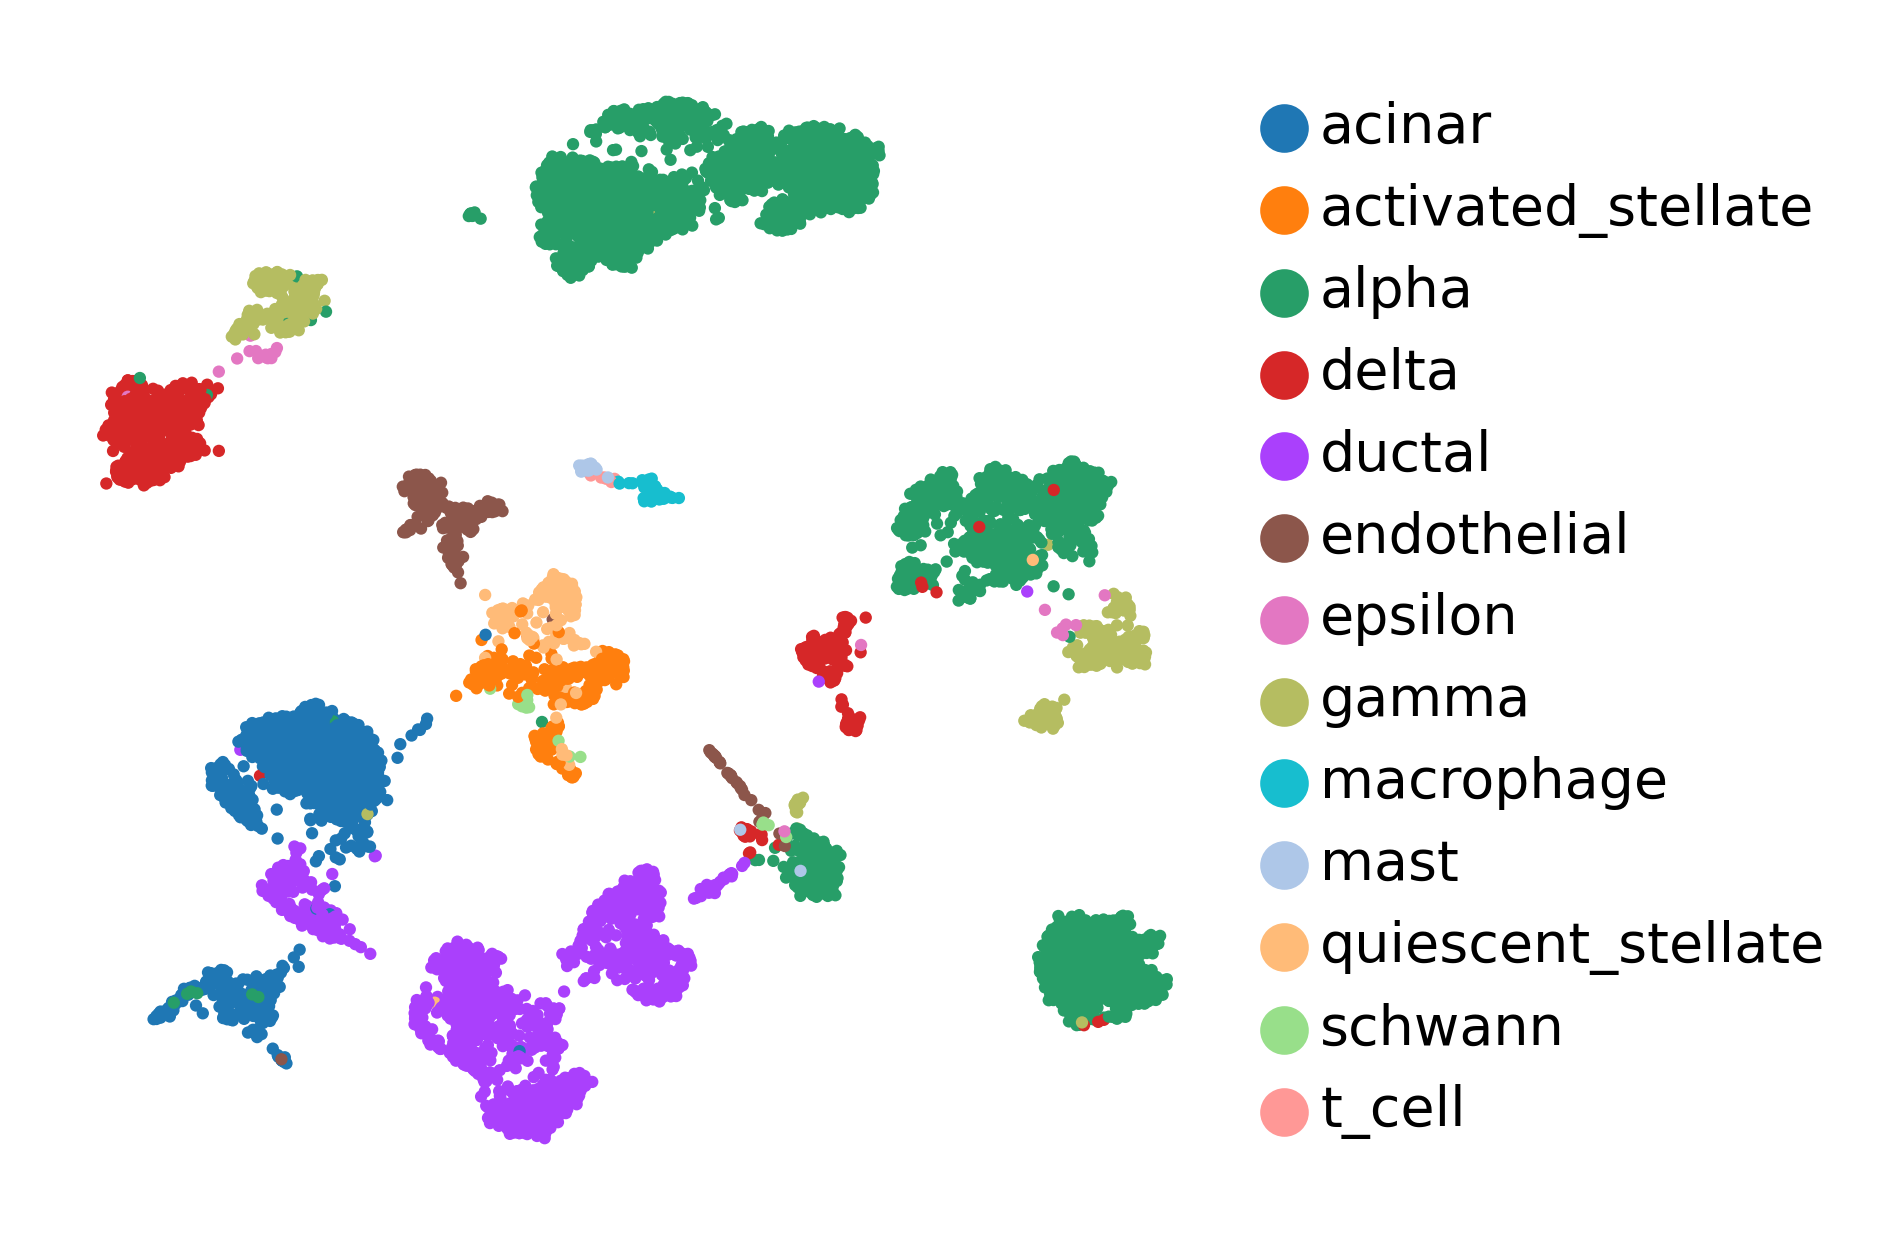

In [16]:
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.dpi'] = 250
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_plot, color='cell_type', frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('', fontsize=10)
fig.savefig('figure1/umap_ct.png', dpi=600, bbox_inches='tight')
#sc.pl.umap(adata_plot[adata_plot.obs['cell_type']=='beta'], size=15, color='cell_type', frameon=False, show=False, ax=ax)

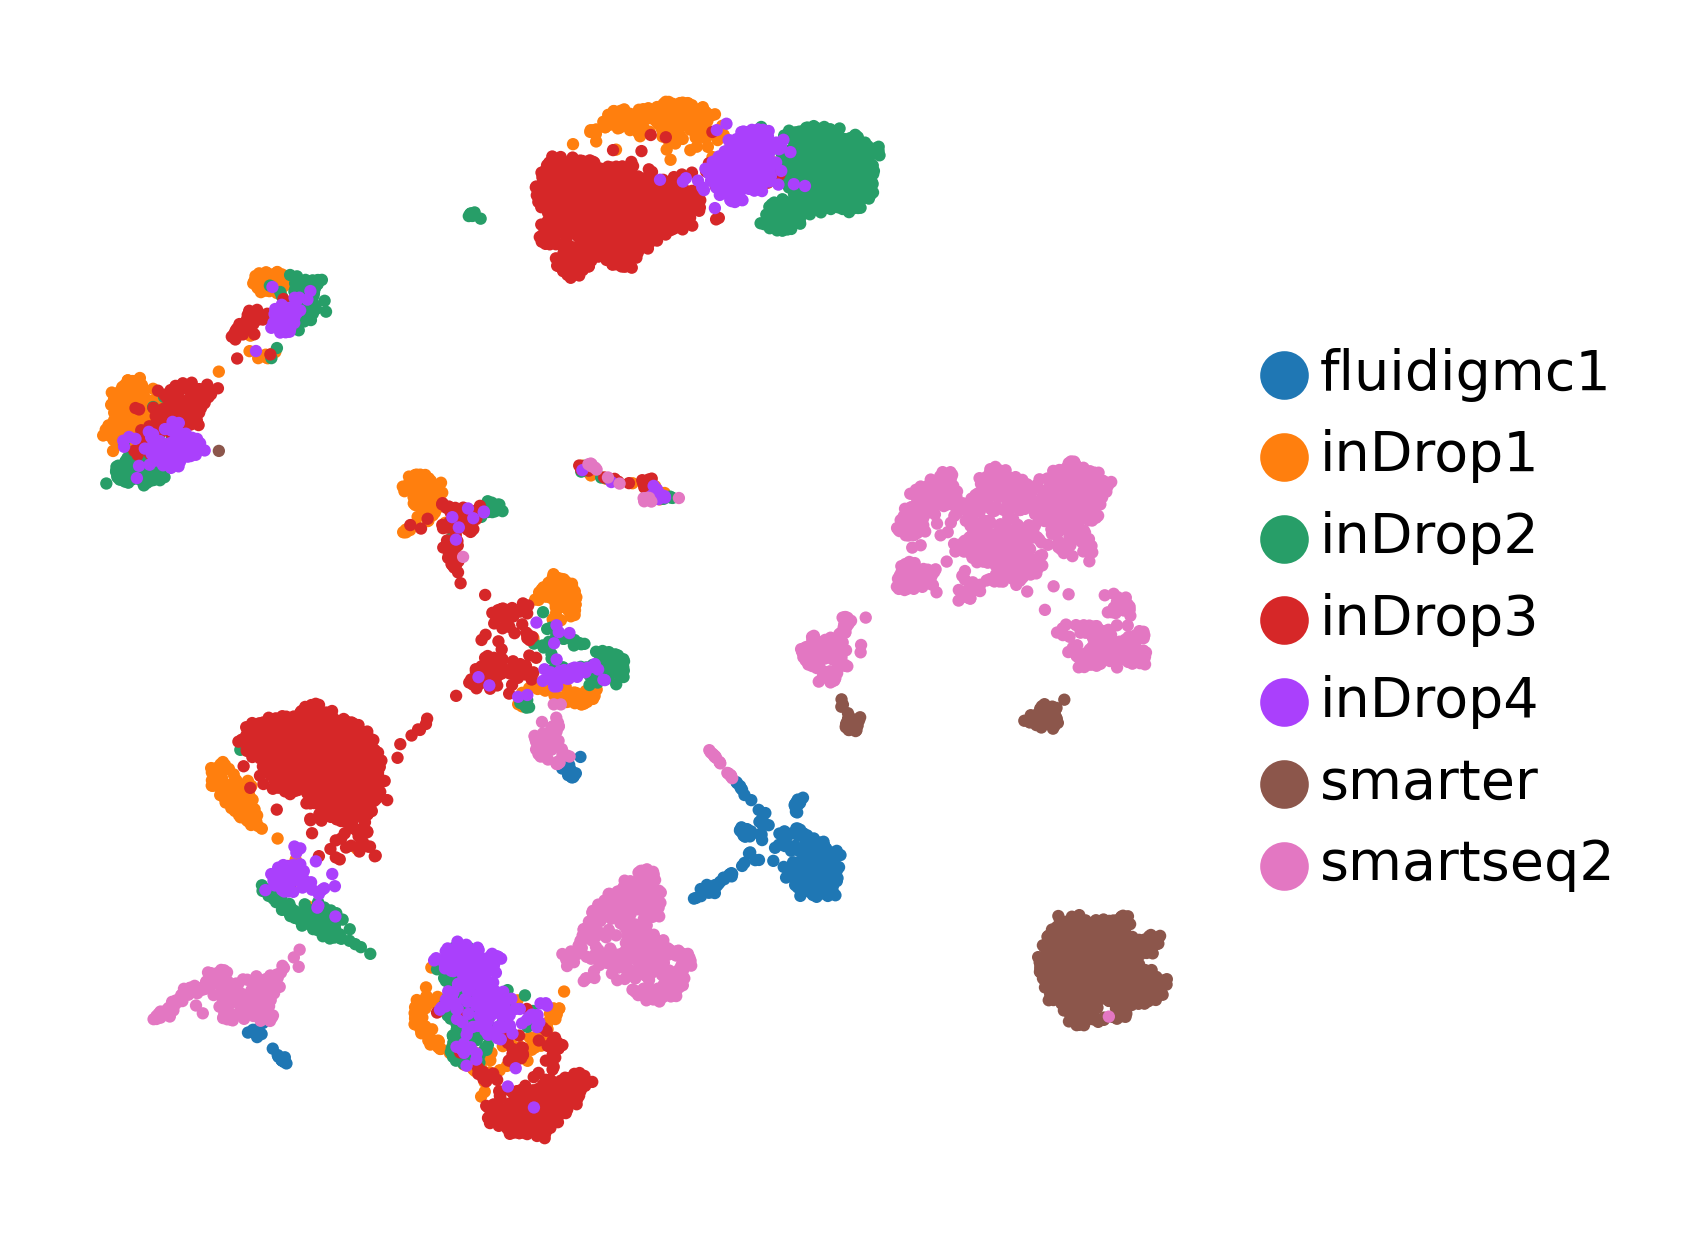

In [17]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_plot, color='study', frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('', fontsize=10)
fig.savefig('figure1/umap_study.png', dpi=600, bbox_inches='tight')
#sc.pl.umap(adata_plot[adata_plot.obs['cell_type']=='beta'], size=15, color='cell_type', frameon=False, show=False, ax=ax)

# Supervised Reference Training (100% labels used)

In [ ]:
lataq_ref = EMBEDCVAE(
    adata=ref_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_keys,
    hidden_layer_sizes=[128, 128, 128],
)

In [ ]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_landmark_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}


In [ ]:
lataq_ref.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    alpha_epoch_anneal=1e6,
    eta=10,
    clustering_res=2,
)

In [11]:
lataq_ref = EMBEDCVAE.load('pancreas/', ref_adata)

AnnData object with n_obs × n_vars = 9530 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    uns: 'neighbors', 'umap'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [ ]:
lataq_ref.save('pancreas/')

In [10]:
lataq_ref = EMBEDCVAE.load('pancreas/', ref_adata)

AnnData object with n_obs × n_vars = 9530 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    uns: 'neighbors', 'umap'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [11]:
data_latent = lataq_ref.get_latent(
    ref_adata.X, 
    ref_adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs = ref_adata.obs.copy()
sc.pp.neighbors(adata_latent, n_neighbors=10)
sc.tl.umap(adata_latent)

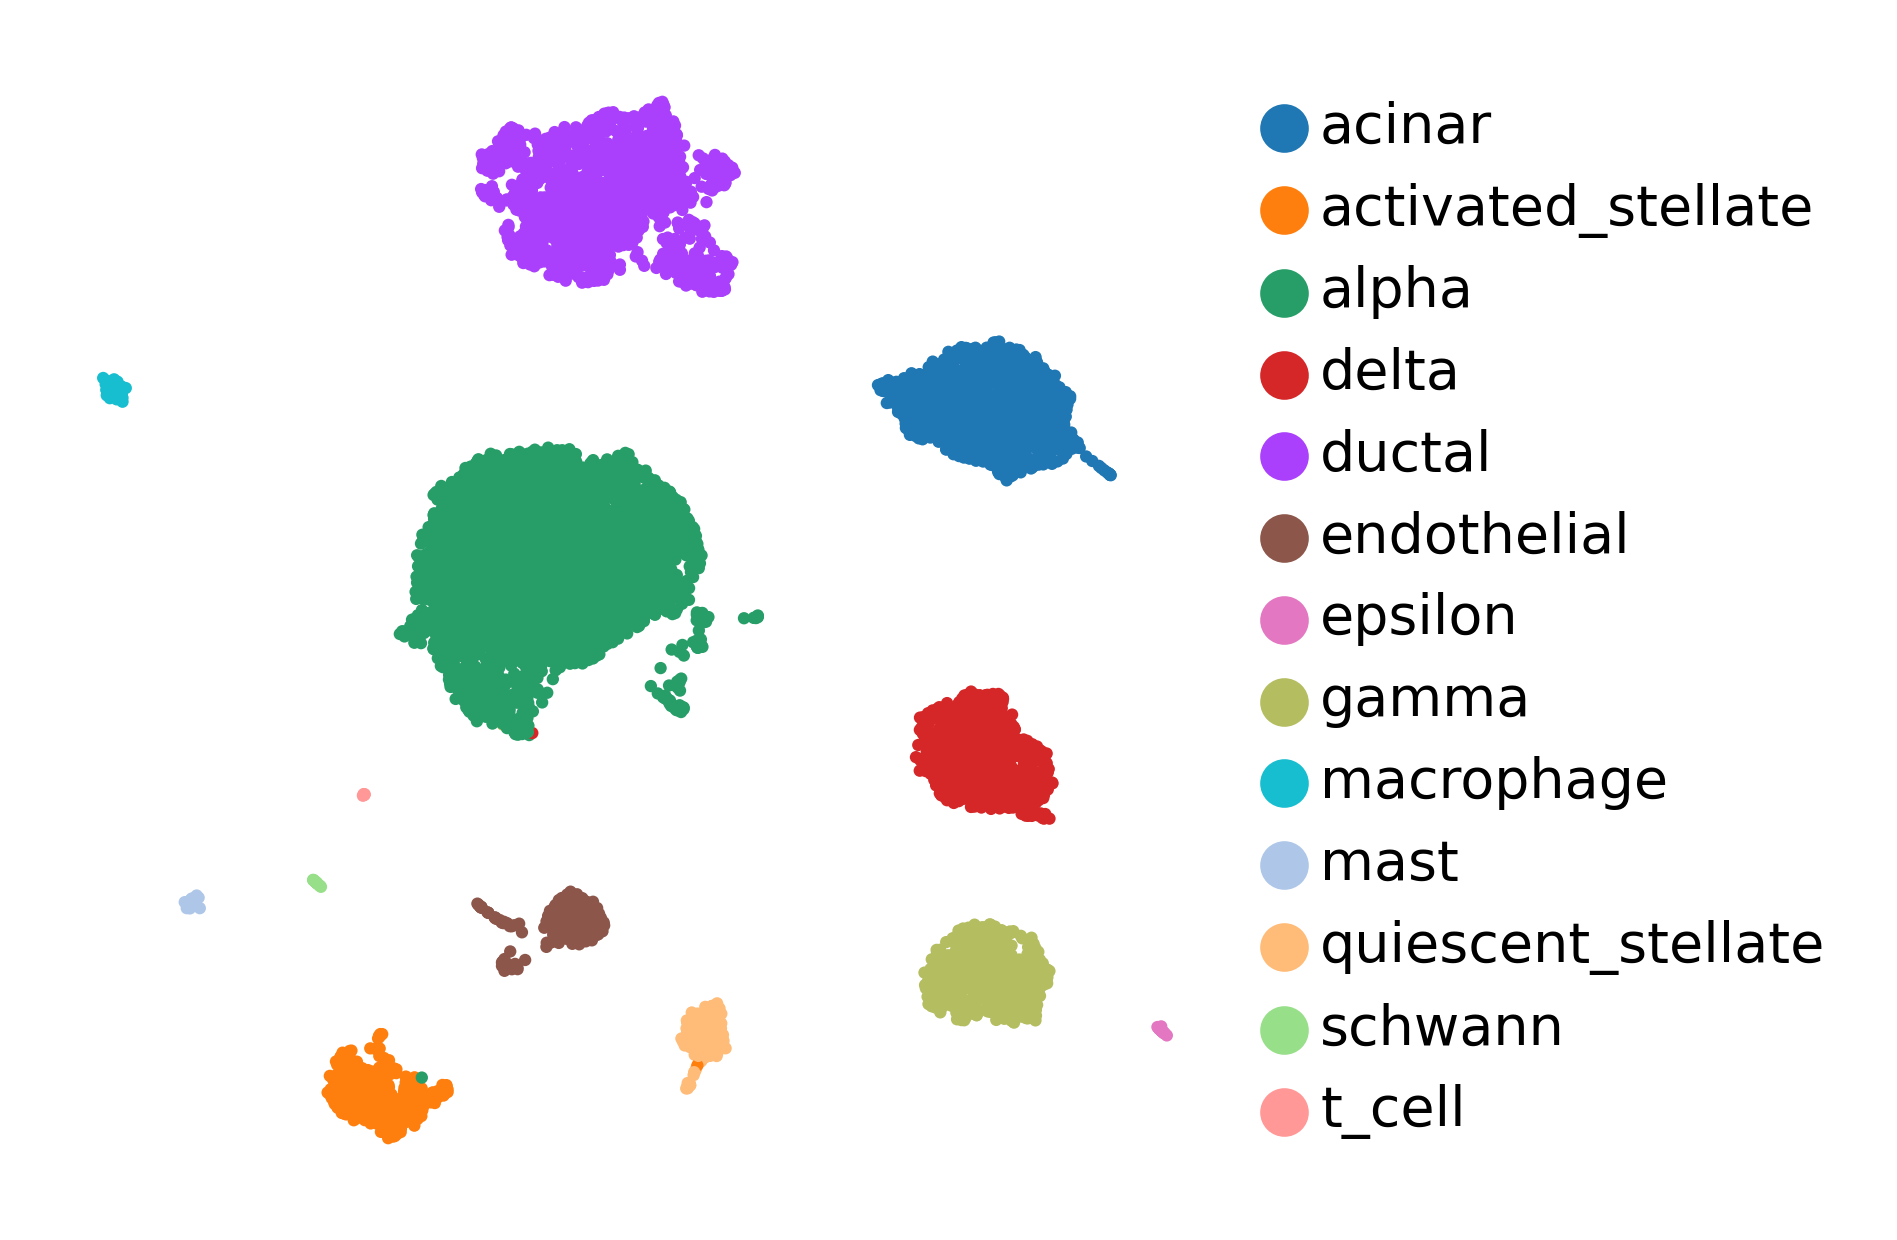

In [20]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_latent, color='cell_type', frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('', fontsize=10)
fig.savefig('figure1/umap_latent_ct.png', dpi=600, bbox_inches='tight')


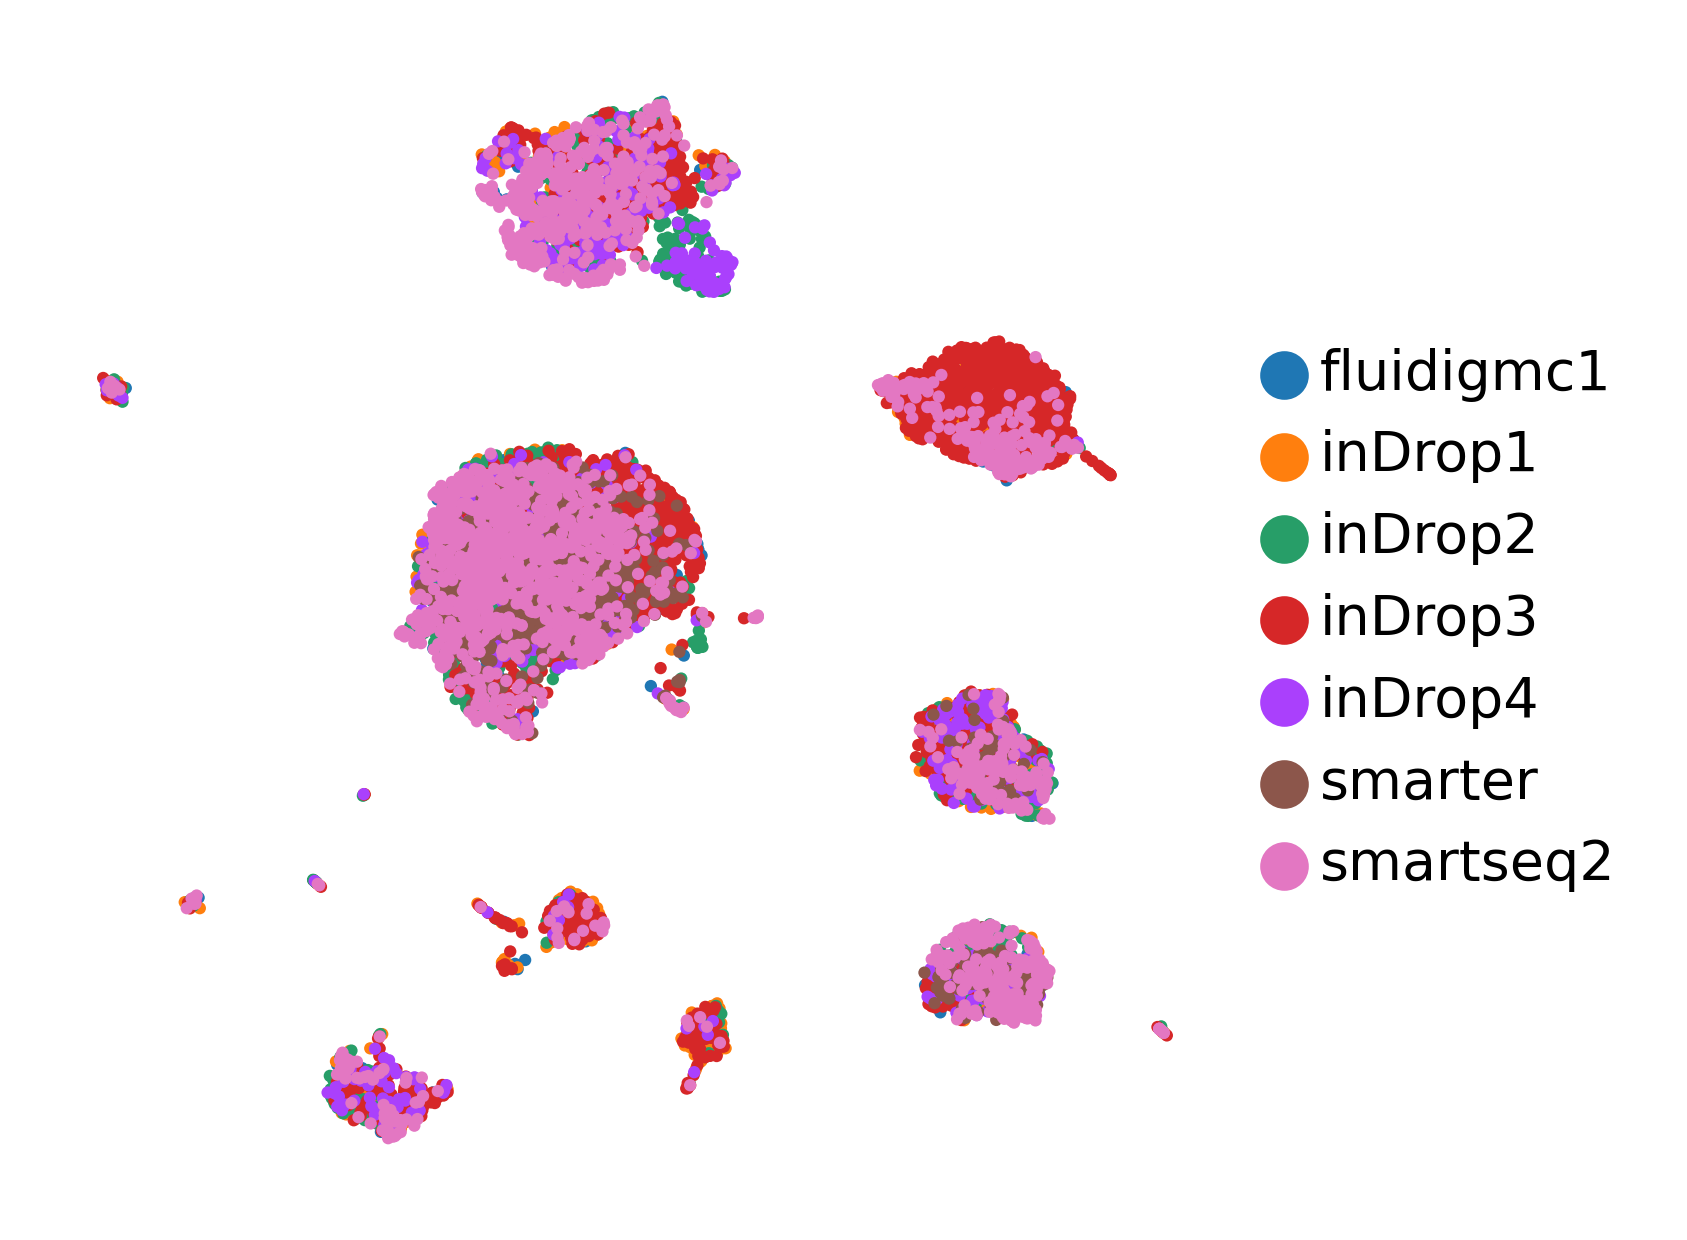

In [21]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(adata_latent, color='study', frameon=False, show=False, ax=ax, alpha=1)
ax.set_title('', fontsize=10)
fig.savefig('figure1/umap_latent_study.png', dpi=600, bbox_inches='tight')


# Unsupervised Query Training (0 labels used)

In [ ]:
lataq = EMBEDCVAE.load_query_data(
    adata=query_adata,
    reference_model='pancreas_wquery',
    labeled_indices=[]
)

In [ ]:
lataq.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    eta=0,
    clustering_res=2,
)

In [85]:
lataq.save(
    'pancreas_wquery',
    overwrite=True
)

In [22]:
lataq = EMBEDCVAE.load('pancreas_wquery', query_adata)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    uns: 'neighbors', 'umap'
    obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 4000 



In [23]:
results_dict_q = lataq.classify(
    x=query_adata.X, 
    c=query_adata.obs[condition_key].values,
    metric="dist",
    get_prob=False,
    threshold=-np.inf
)
preds_q = results_dict_q[cell_type_key]['preds']
probs_q = results_dict_q[cell_type_key]['probs']
probs_log = np.log1p(probs_q)
is_novel = probs_log < 0.05

In [24]:
lataq.model.eval()
data_latent_ref = lataq.get_latent(
    ref_adata.X, 
    ref_adata.obs[condition_key].values,
    mean=True
)

adata_latent_ref = sc.AnnData(data_latent_ref)
adata_latent_ref.obs = ref_adata.obs.copy()

lataq.model.eval()
data_latent= lataq.get_latent(
    query_adata.X, 
    query_adata.obs[condition_key].values,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = query_adata.obs.copy()

adata_latent.obs[f'{cell_type_key}_pred'] = preds_q.tolist()
adata_latent.obs[f'{cell_type_key}_prob'] = probs_q.tolist()
adata_latent.obs['log_probs'] = probs_log
adata_latent.obs[f'{cell_type_key}_pred'][adata_latent.obs['log_probs'] > 0.06] = 'unknown'
adata_latent.obs[f'classifier_outcome'] = (
    adata_latent.obs[f'{cell_type_key}_pred'] == adata_latent.obs[f'{cell_type_key}']
)
adata_latent.obs['classifier_outcome'] = adata_latent.obs['classifier_outcome'].astype(str)
adata_latent.obs['classifier_outcome'][adata_latent.obs['cell_type_pred']=='unknown'] = 'Unknown'

labeled_set = lataq.get_landmarks_info()
labeled_set.obs['condition'] = 'labeled landmark'
unlabeled_set = lataq.get_landmarks_info(landmark_set='unlabeled')
unlabeled_set.obs['condition'] = 'unlabeled landmark'

adata_latent_full = adata_latent_ref.concatenate([adata_latent, labeled_set, unlabeled_set], batch_key='query')
print(adata_latent_full.obs.groupby('cell_type_pred').size())
print(adata_latent_full.obs['cell_type_pred'].unique())
adata_latent_full.obs['cell_type_pred'][adata_latent_full.obs['query'].isin(['0'])] = 'reference'
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

<ipython-input-24-a9007287c91d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_latent.obs[f'{cell_type_key}_pred'][adata_latent.obs['log_probs'] > 0.06] = 'unknown'
<ipython-input-24-a9007287c91d>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_latent.obs['classifier_outcome'][adata_latent.obs['cell_type_pred']=='unknown'] = 'Unknown'
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to 

cell_type_pred
acinar                461
activated_stellate    116
alpha                 906
delta                 395
ductal                538
endothelial            28
epsilon                 5
gamma                 126
macrophage             16
mast                    6
quiescent_stellate      8
schwann                 6
t_cell                  1
unknown               715
dtype: int64
[nan 'gamma' 'unknown' 'acinar' 'alpha' 'ductal' 'activated_stellate'
 'delta' 'endothelial' 'schwann' 'epsilon' 'quiescent_stellate' 'mast'
 'macrophage' 't_cell']


<ipython-input-25-1e2902fde579>:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_noland.obs['cell_type_pred'] = adata_noland.obs['cell_type_pred'].astype('category')
<ipython-input-25-1e2902fde579>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_land.obs['cell_type_pred'] = adata_land.obs['cell_type_pred'].astype('category')
<ipython-input-25-1e2902fde579>:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_land_unlab.obs['cell_type_pred'] = adata_land_unlab.obs['cell_type_pred'].astype('category')


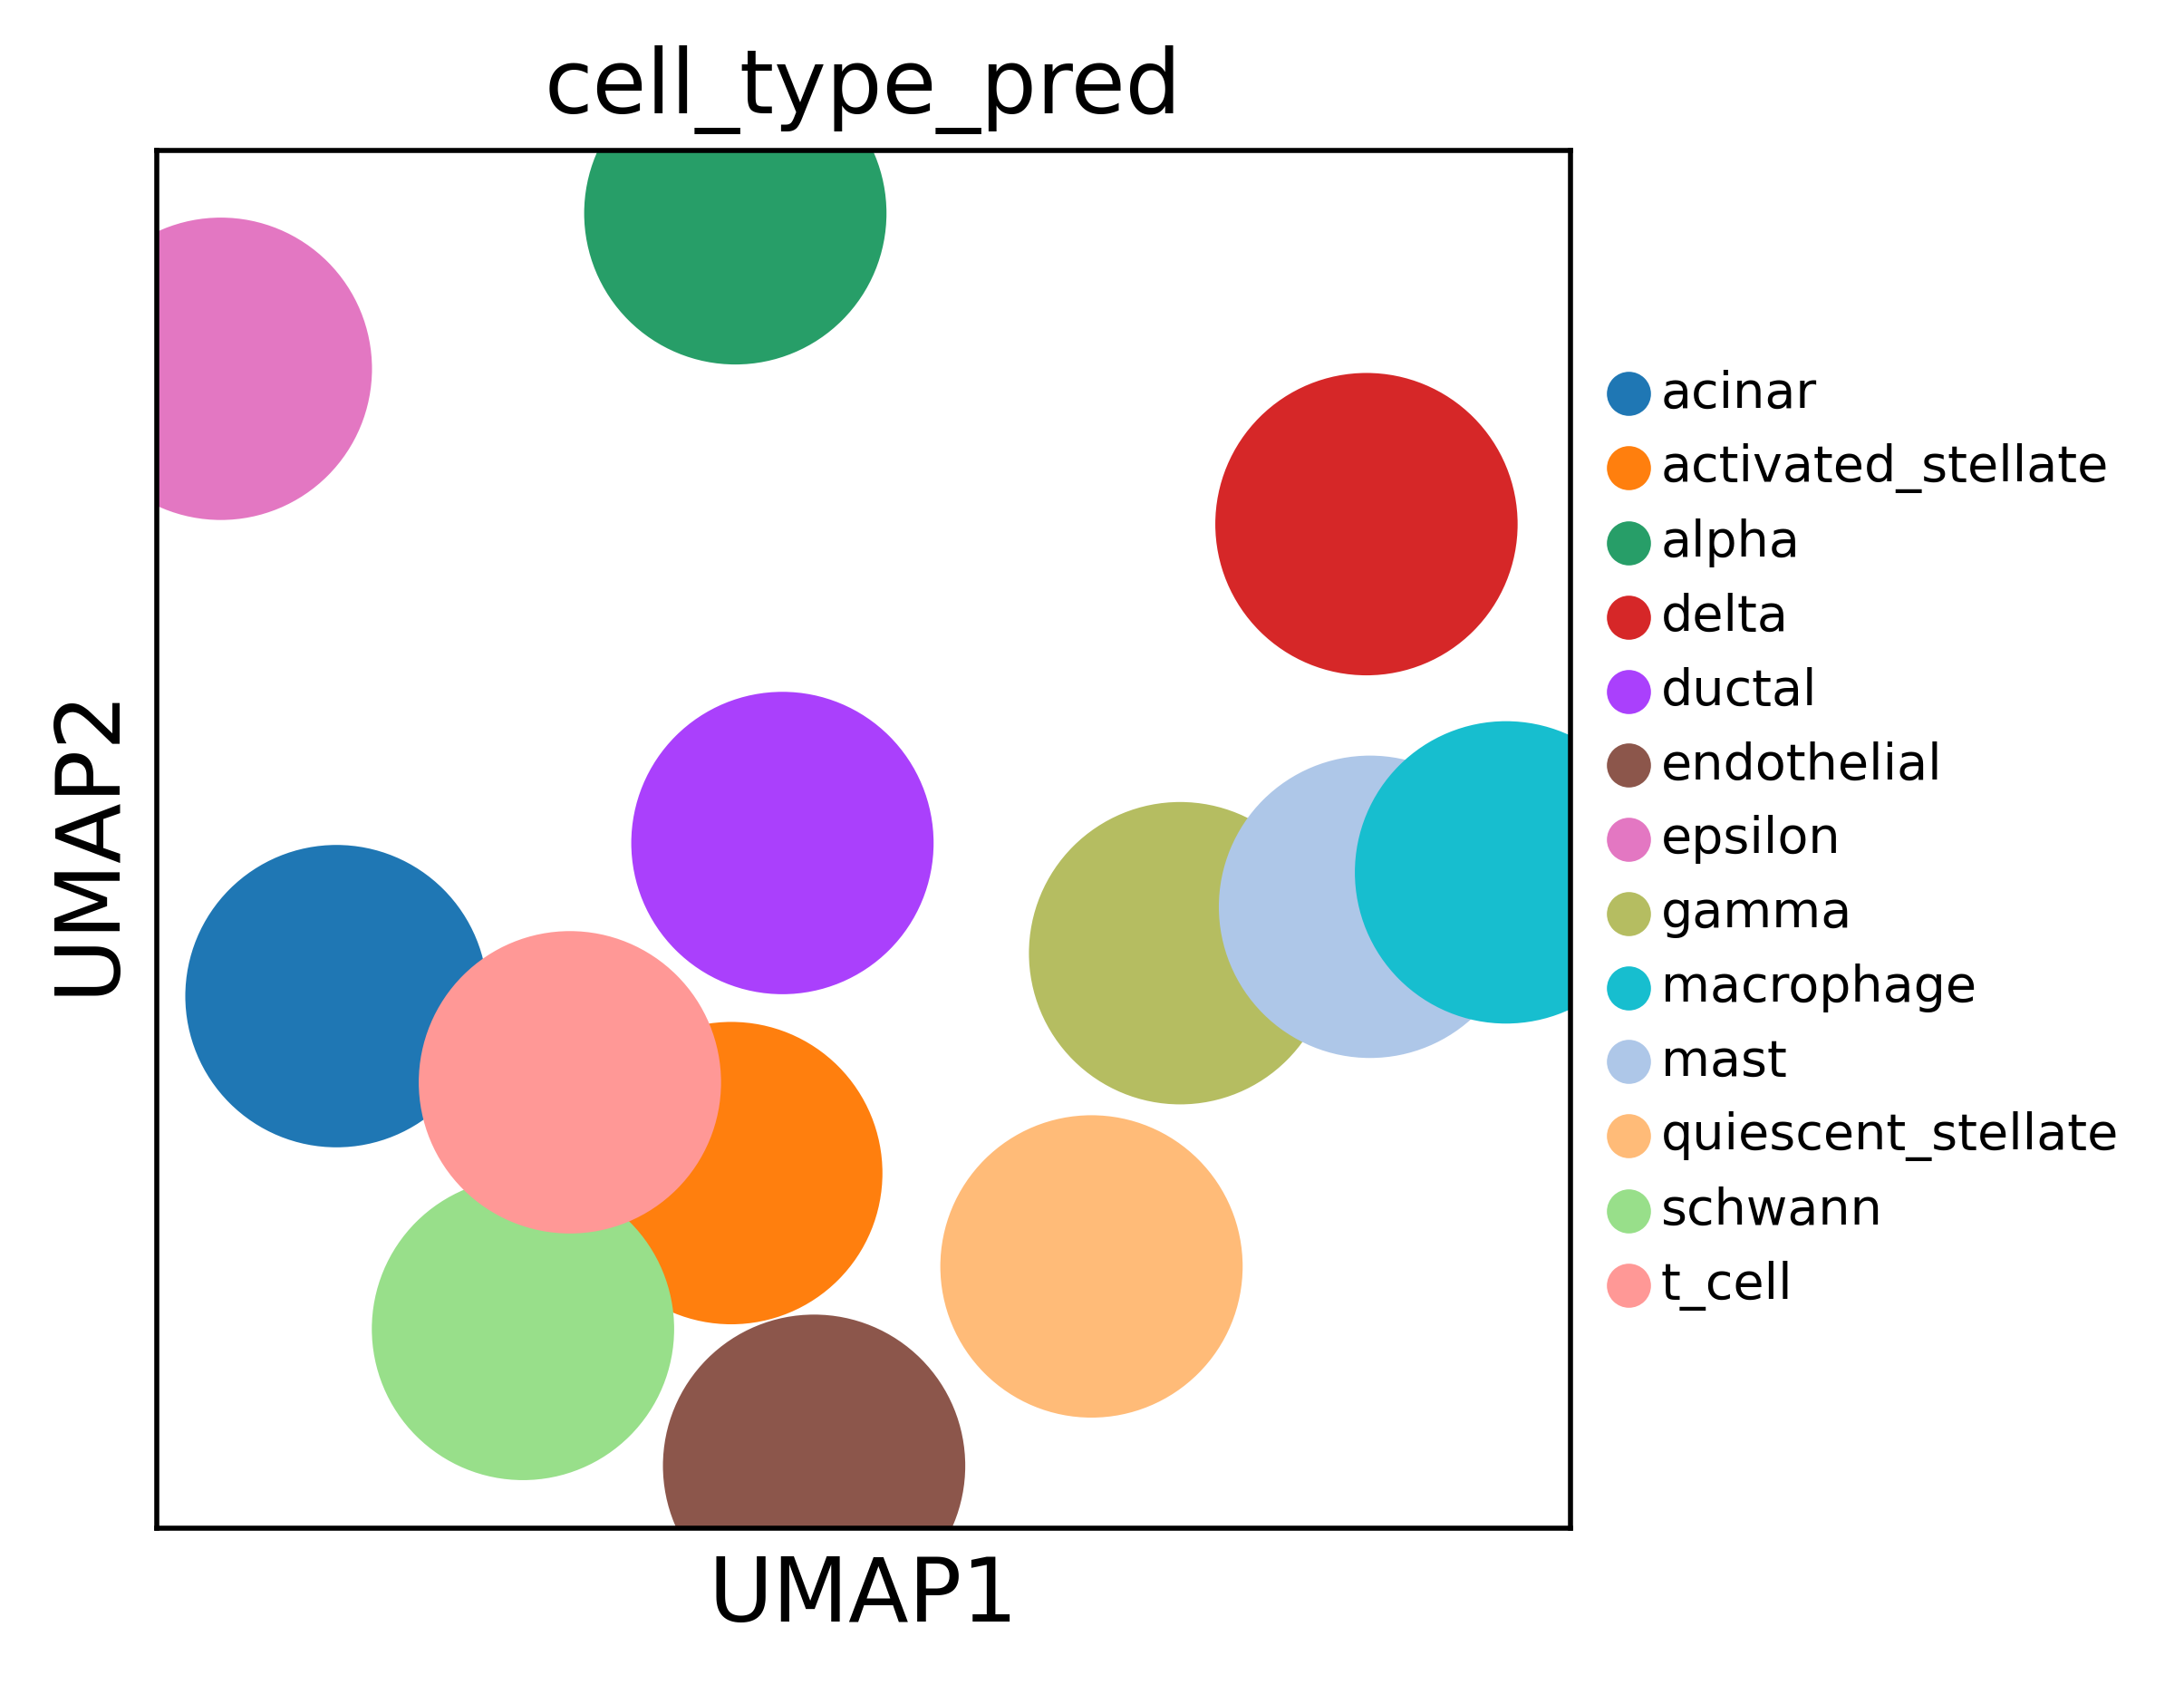

In [25]:
adata_noland = adata_latent_full[adata_latent_full.obs['query'].isin(['0', '1'])]
adata_land = adata_latent_full[adata_latent_full.obs['query'].isin(['2'])]
adata_land_unlab = adata_latent_full[adata_latent_full.obs['query'].isin(['3'])]
adata_noland.obs['cell_type_pred'] = adata_noland.obs['cell_type_pred'].astype('category')
adata_land.obs['cell_type_pred'] = adata_land.obs['cell_type_pred'].astype('category')
adata_land_unlab.obs['cell_type_pred'] = adata_land_unlab.obs['cell_type_pred'].astype('category')
sc.pl.umap(adata_land, color='cell_type_pred')

Text(0.5, 1.0, '')

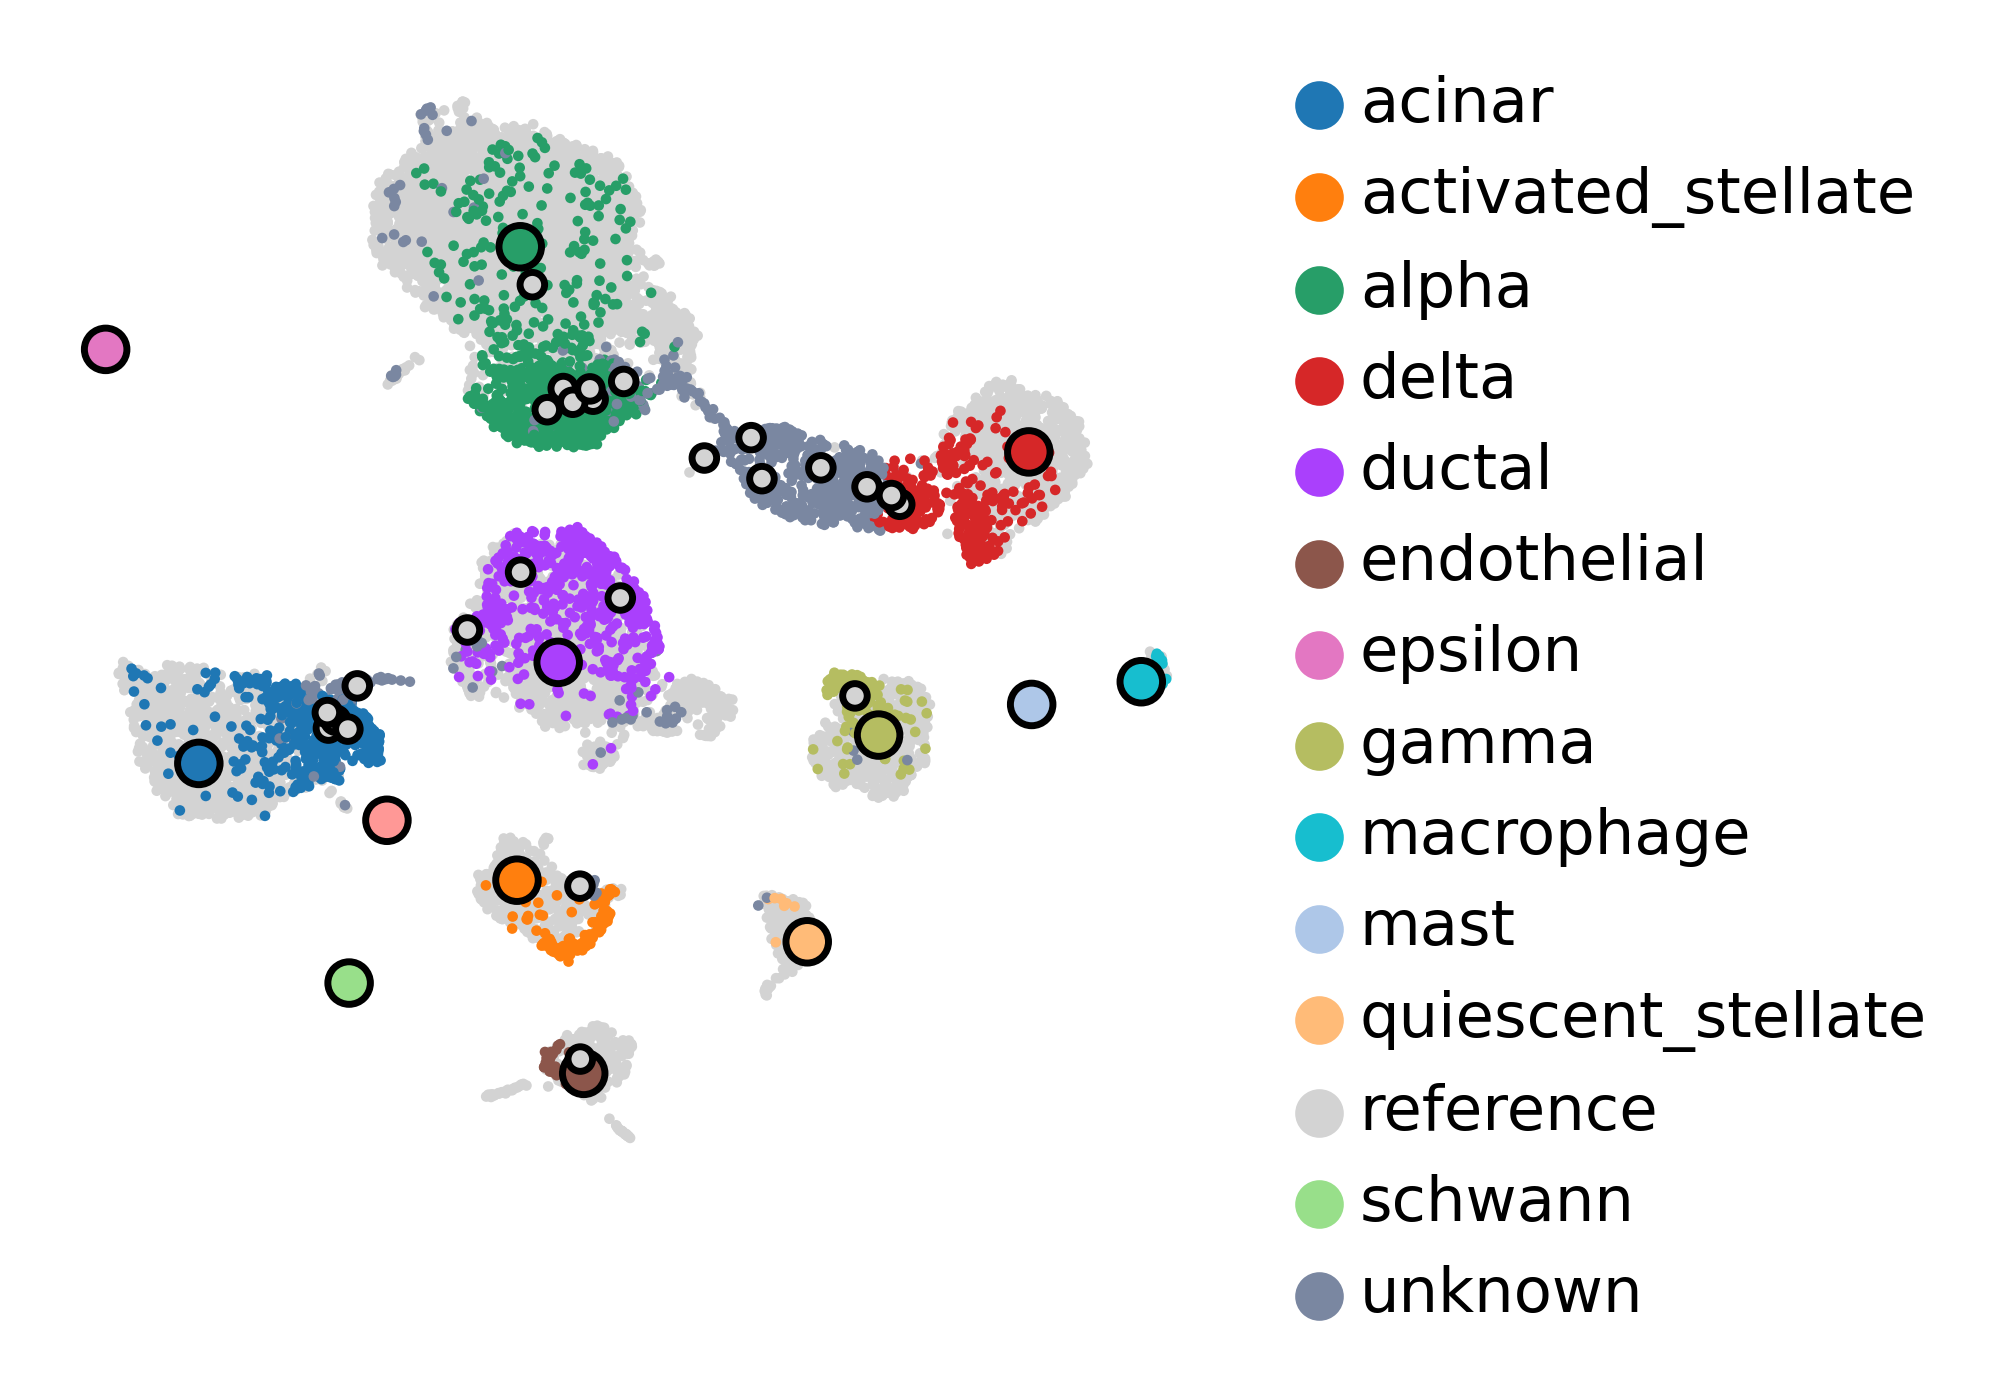

In [28]:
palette_dict = dict(zip(adata_land.obs['cell_type_pred'].cat.categories, adata_land.uns['cell_type_pred_colors']))
palette_dict['unknown'] = '#7a87a1'
palette_dict['reference'] = '#d3d3d3'

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    adata_noland, 
    color='cell_type_pred',
    show=False, 
    ax=ax, 
    frameon=False,
    palette=palette_dict
)
sc.pl.umap(
    adata_land, 
    color='cell_type_pred',
    palette=palette_dict,
    ax=ax,
    size=150, 
    edgecolor='black', 
    show=False
)
sc.pl.umap(
    adata_land_unlab, 
    #color='cell_type_pred',
    #palette=palette_dict,
    ax=ax,
    size=50, 
    edgecolor='black', 
    show=False
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles = h[:14], labels = l[:14], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=9, ncol=1, frameon=False)
ax.set_title('')

Text(0.5, 1.0, '')

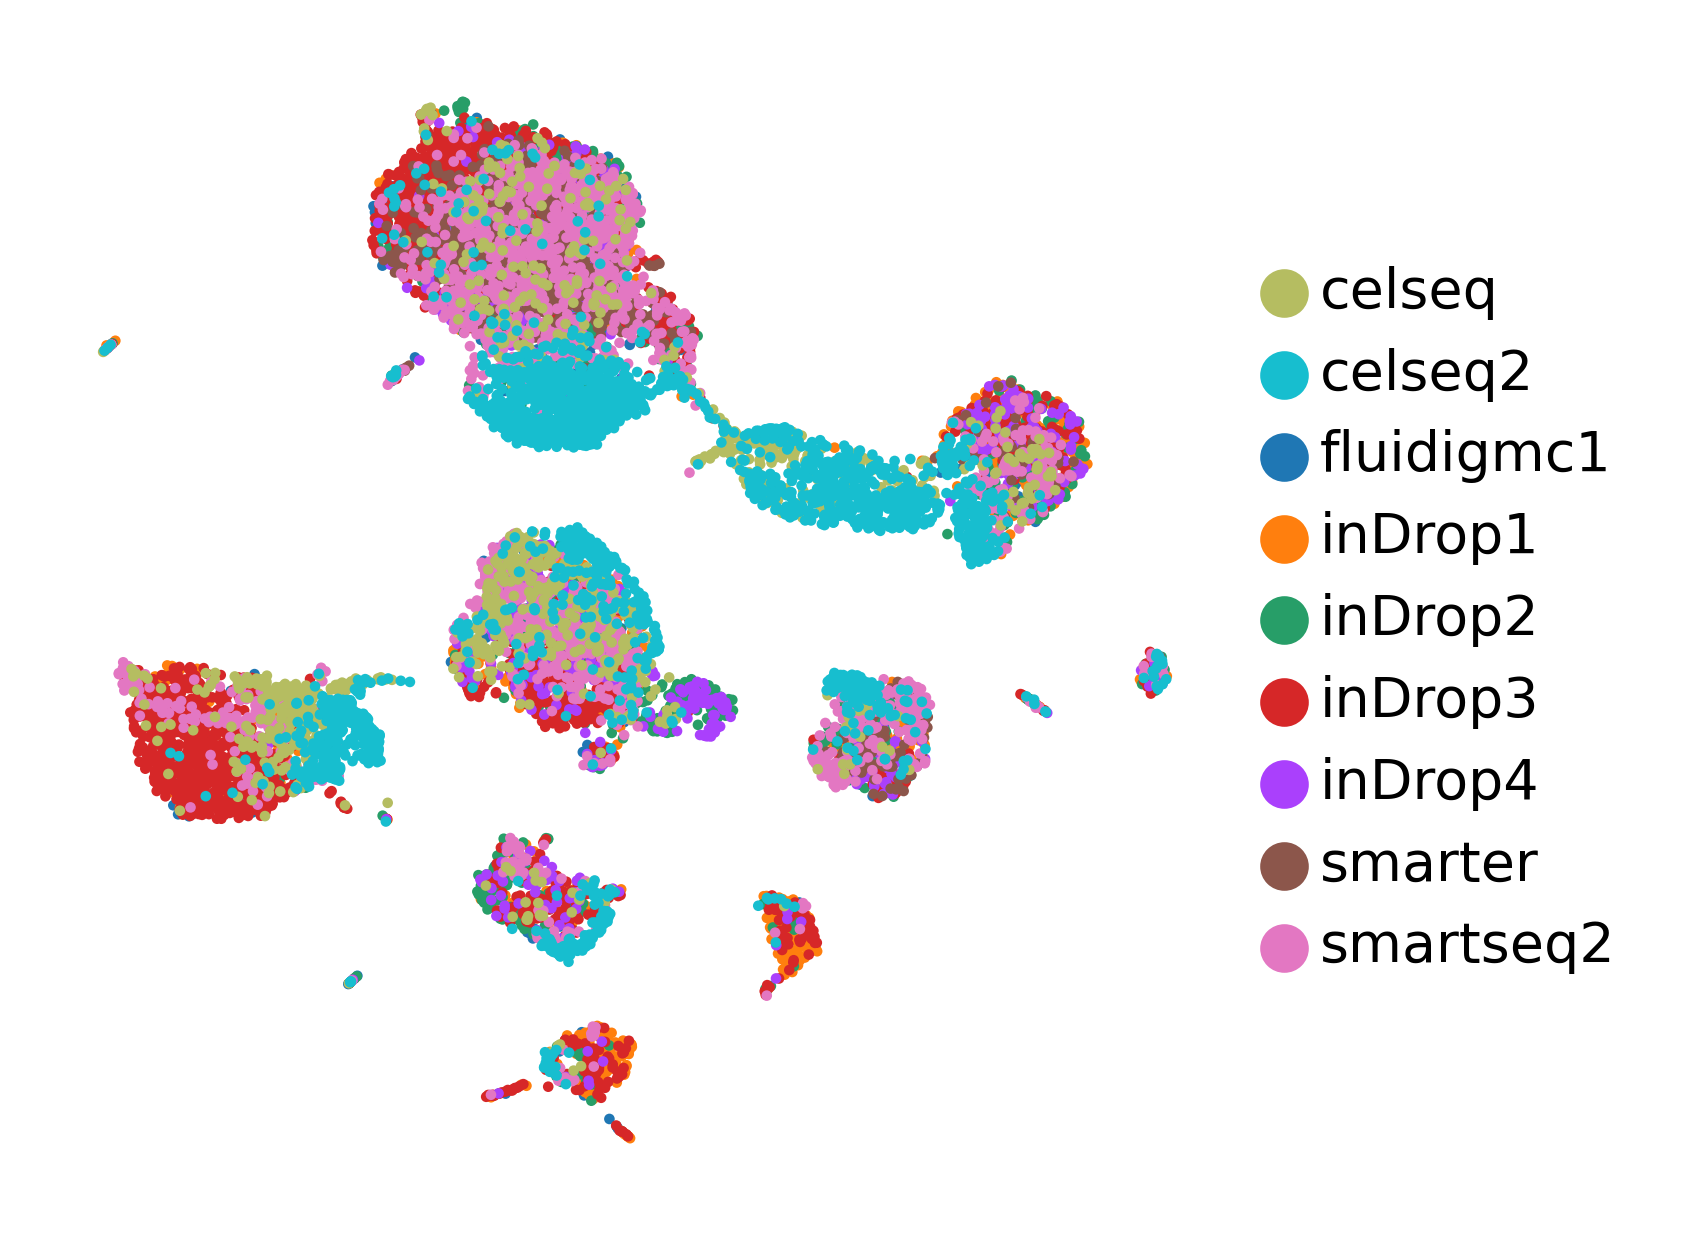

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    adata_noland, 
    color='study',
    show=False, 
    ax=ax, 
    frameon=False,
    palette=palette_study
)
ax.set_title('')

Text(0.5, 1.0, 'Study')

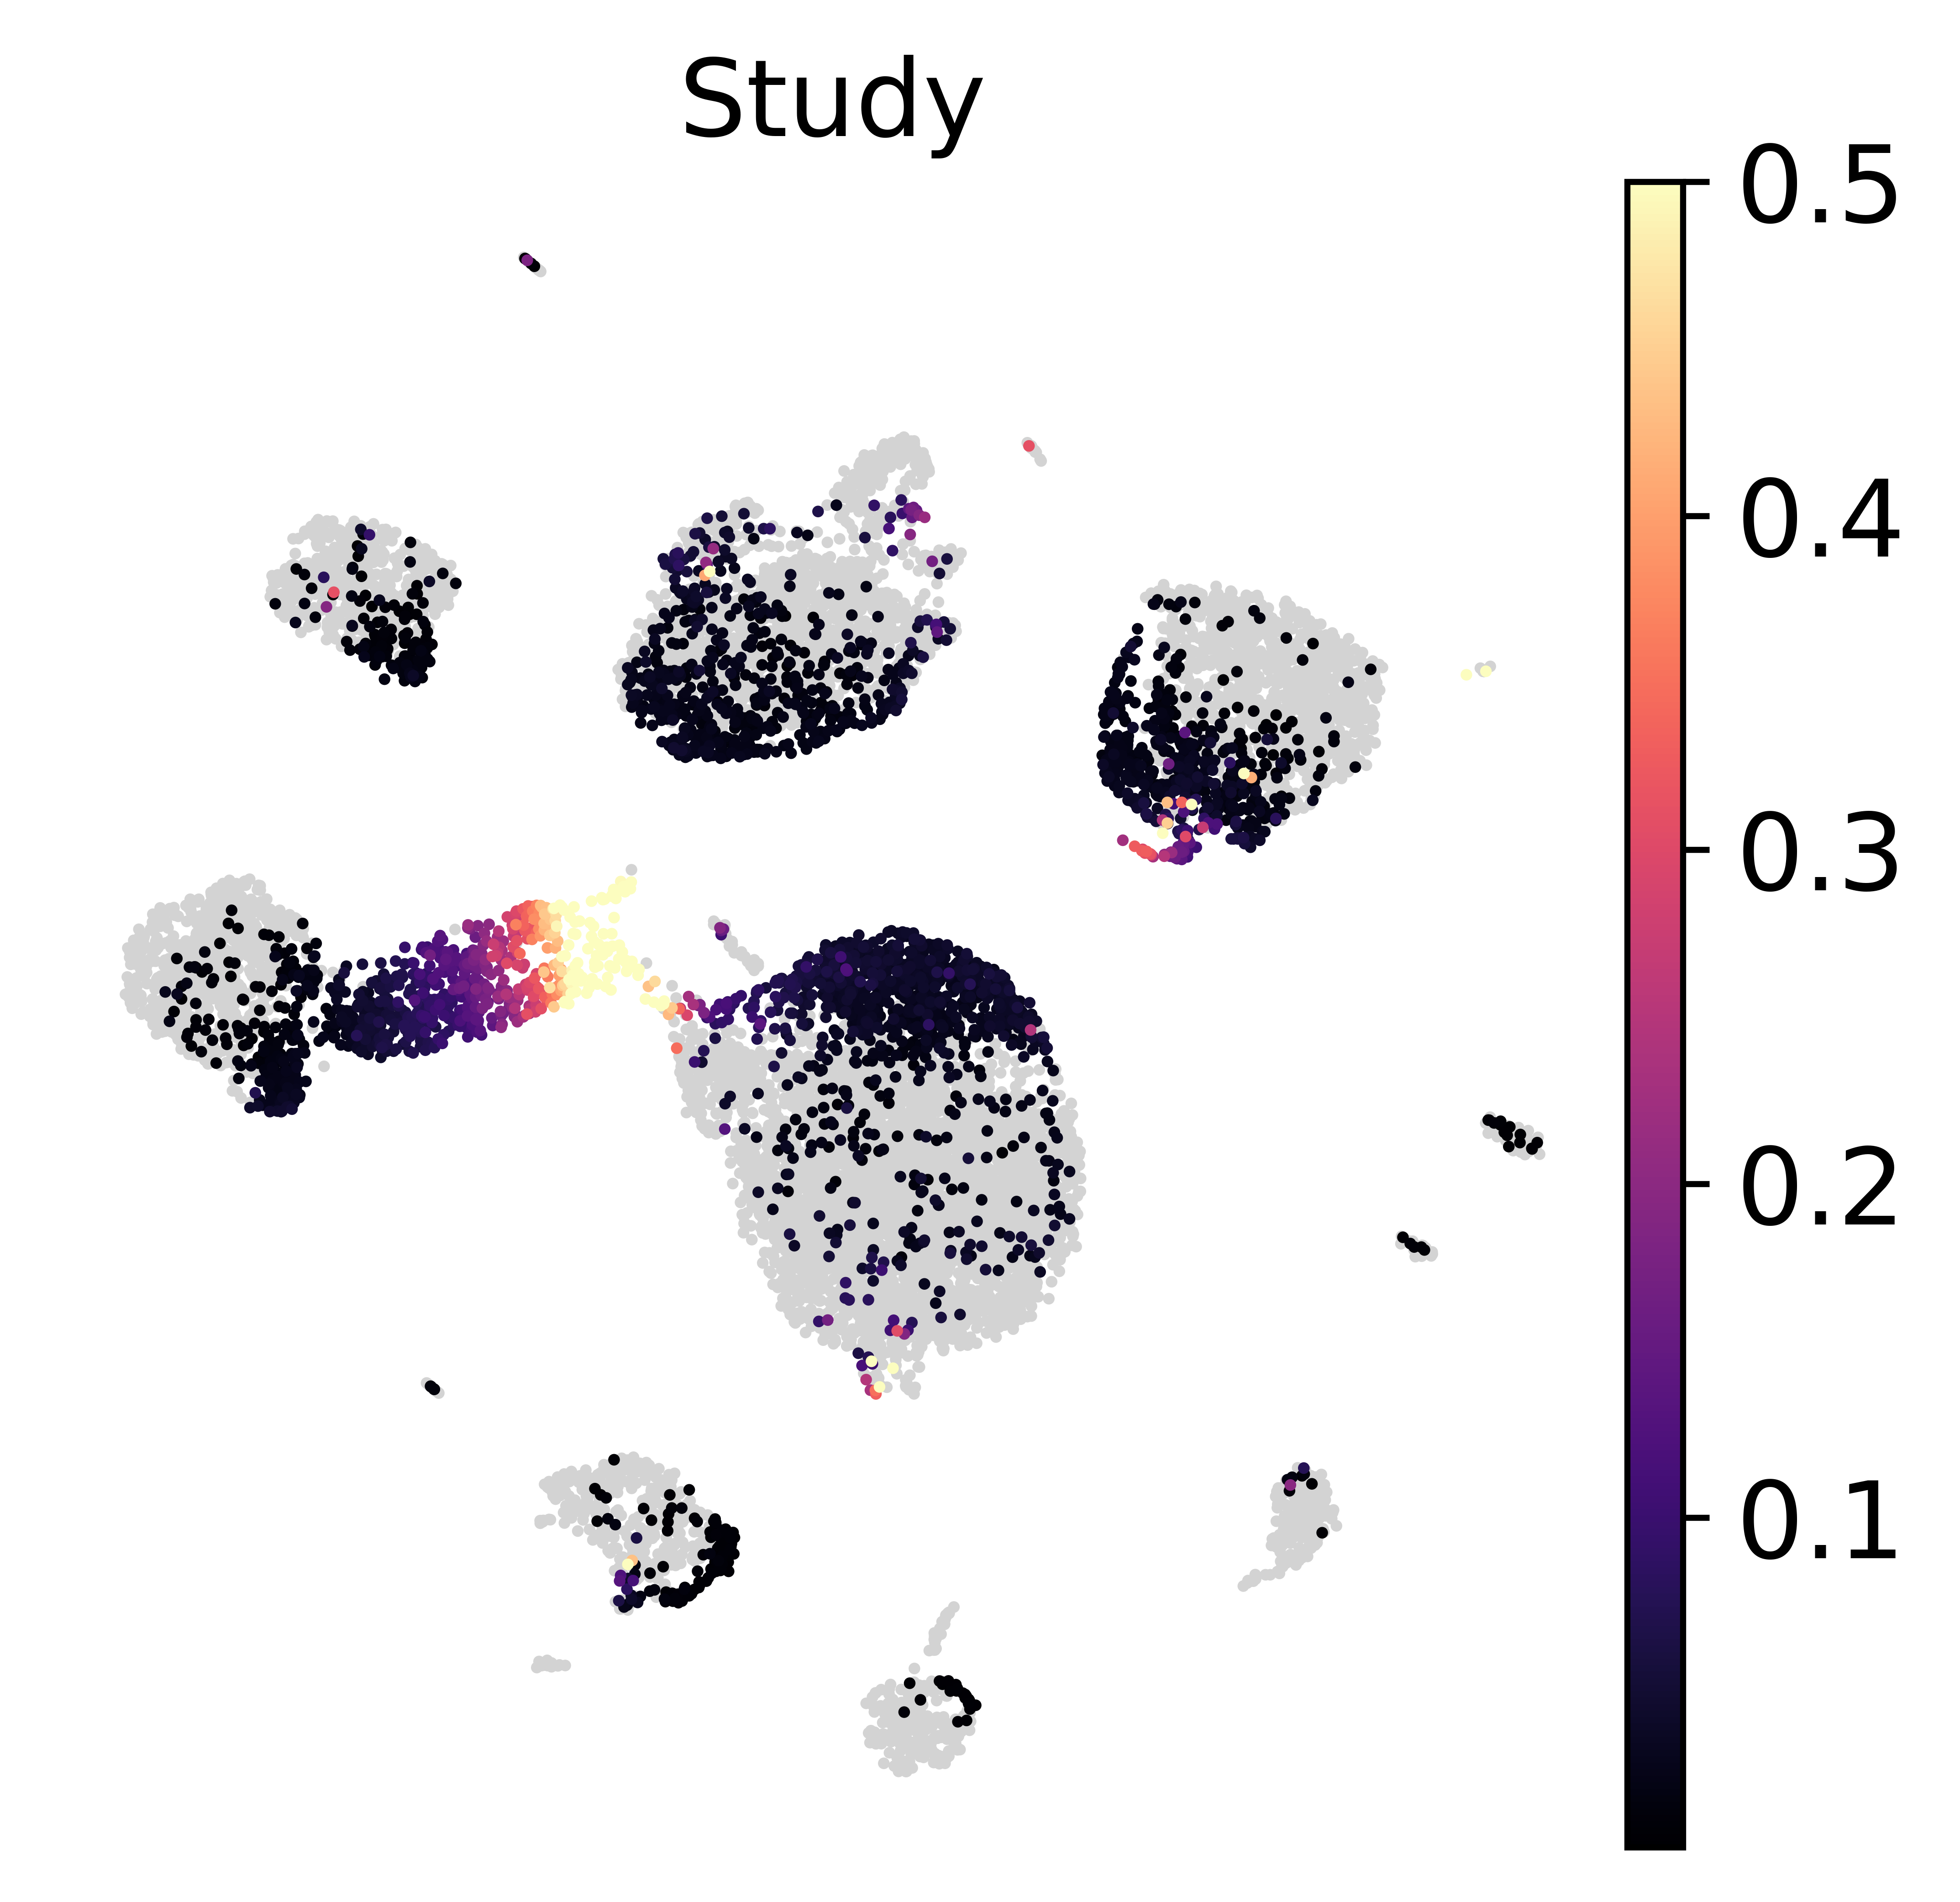

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
sc.pl.umap(
    adata_noland, 
    color='log_probs',
    show=False, 
    ax=ax, 
    frameon=False,
    cmap='magma',
    vmax=0.5
)
ax.set_title('Study')

In [35]:
sns.color_palette().as_hex()[

['#1f77b4',
 '#ff7f0e',
 '#279e68',
 '#d62728',
 '#aa40fc',
 '#8c564b',
 '#e377c2',
 '#b5bd61',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a',
 '#ff9896',
 '#c5b0d5',
 '#c49c94',
 '#f7b6d2',
 '#dbdb8d',
 '#9edae5',
 '#ad494a',
 '#8c6d31']

Text(0.5, 1.0, '')

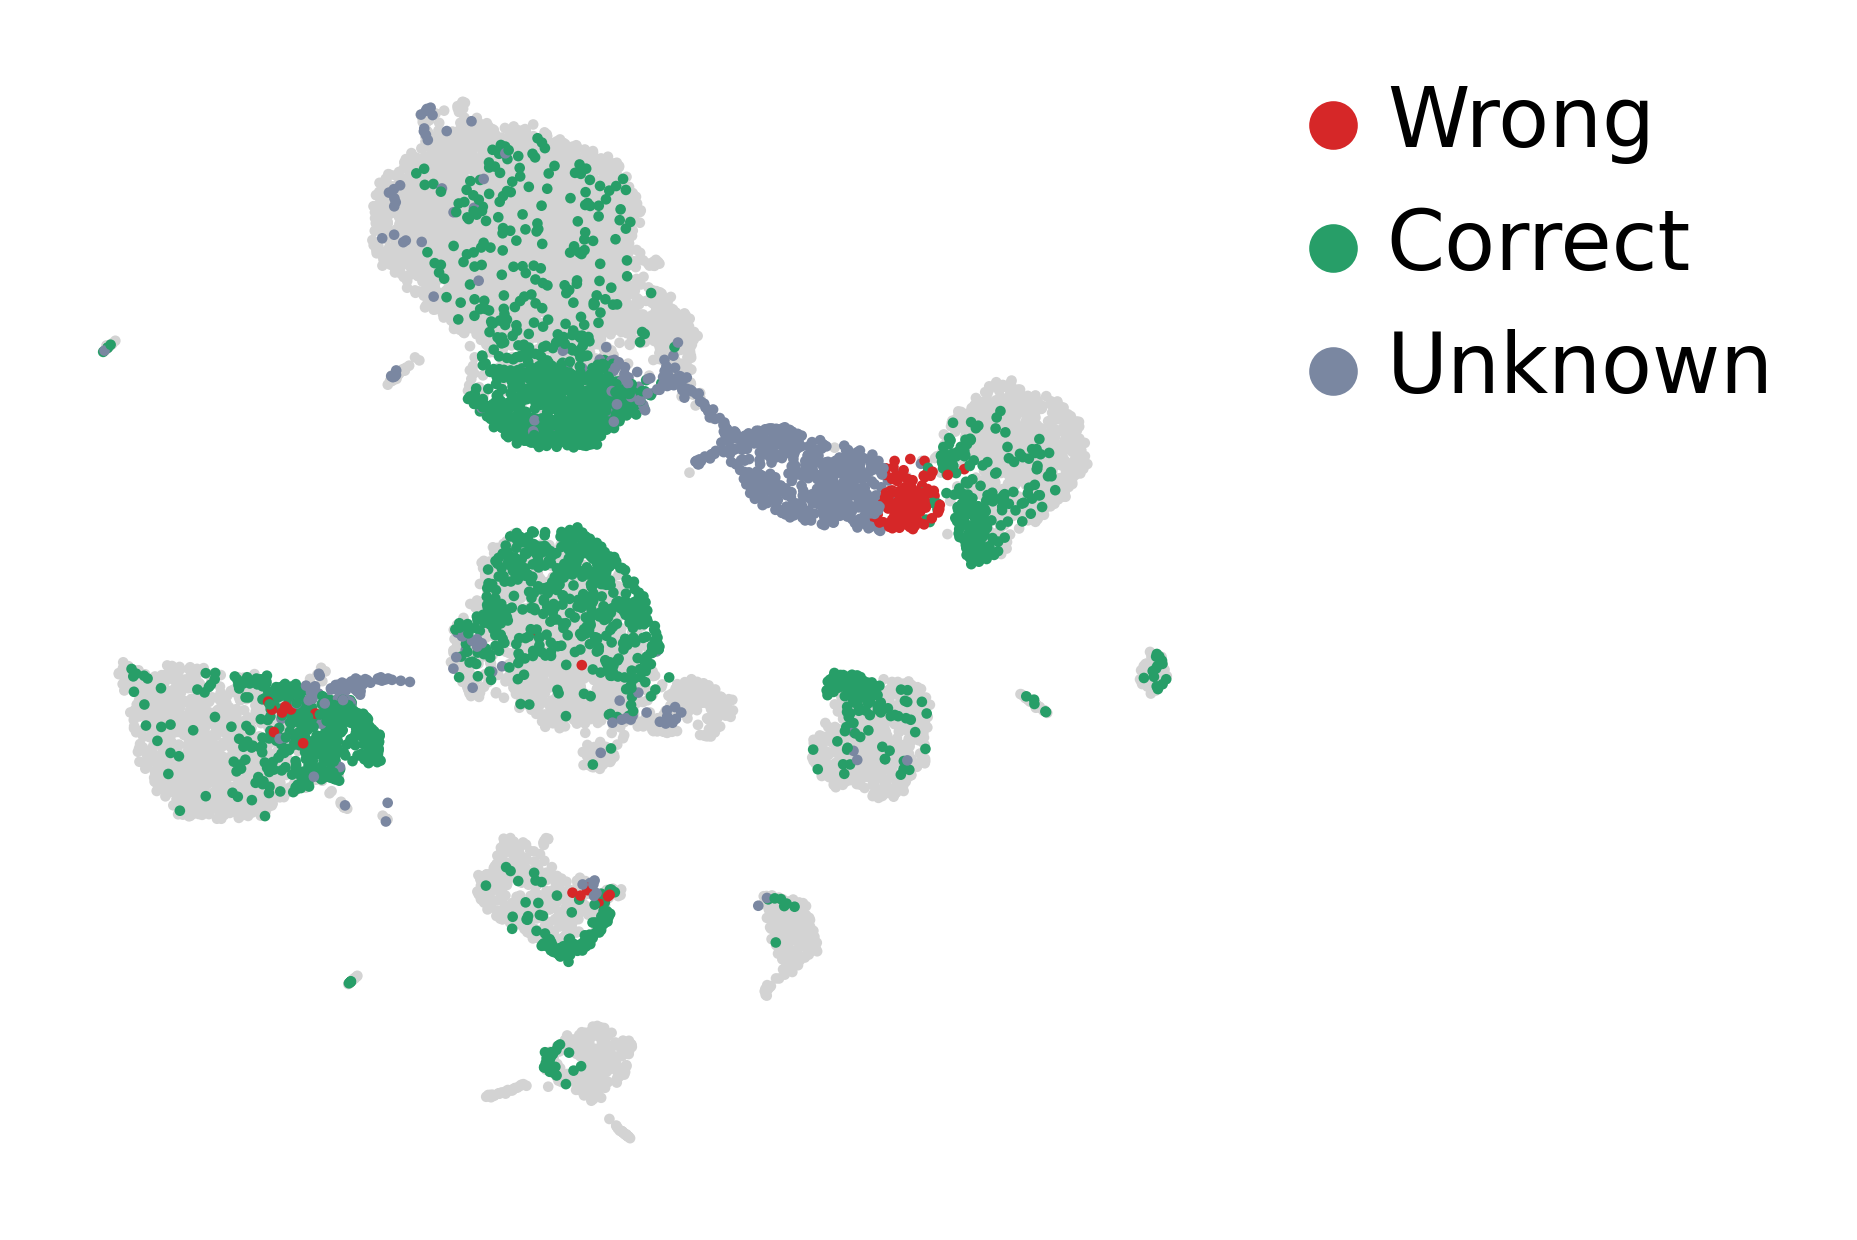

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
adata_noland.obs['classifier_outcome_plot'] = adata_noland.obs['classifier_outcome'].map(
    {
        'False': 'Wrong',
        'True': 'Correct',
        'Unknown': 'Unknown'
    }
)
class_palette = {
    'Wrong': sns.color_palette().as_hex()[3],
    'Correct': sns.color_palette().as_hex()[2],
    'Unknown': '#7a87a1'
}

sc.pl.umap(
    adata_noland, 
    color='classifier_outcome_plot',
    show=False, 
    ax=ax, 
    frameon=False,
    palette=class_palette,
)
h, l = ax.get_legend_handles_labels()
ax.legend(handles = h[:3], labels = l[:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12, ncol=1, frameon=False)
ax.set_title('')

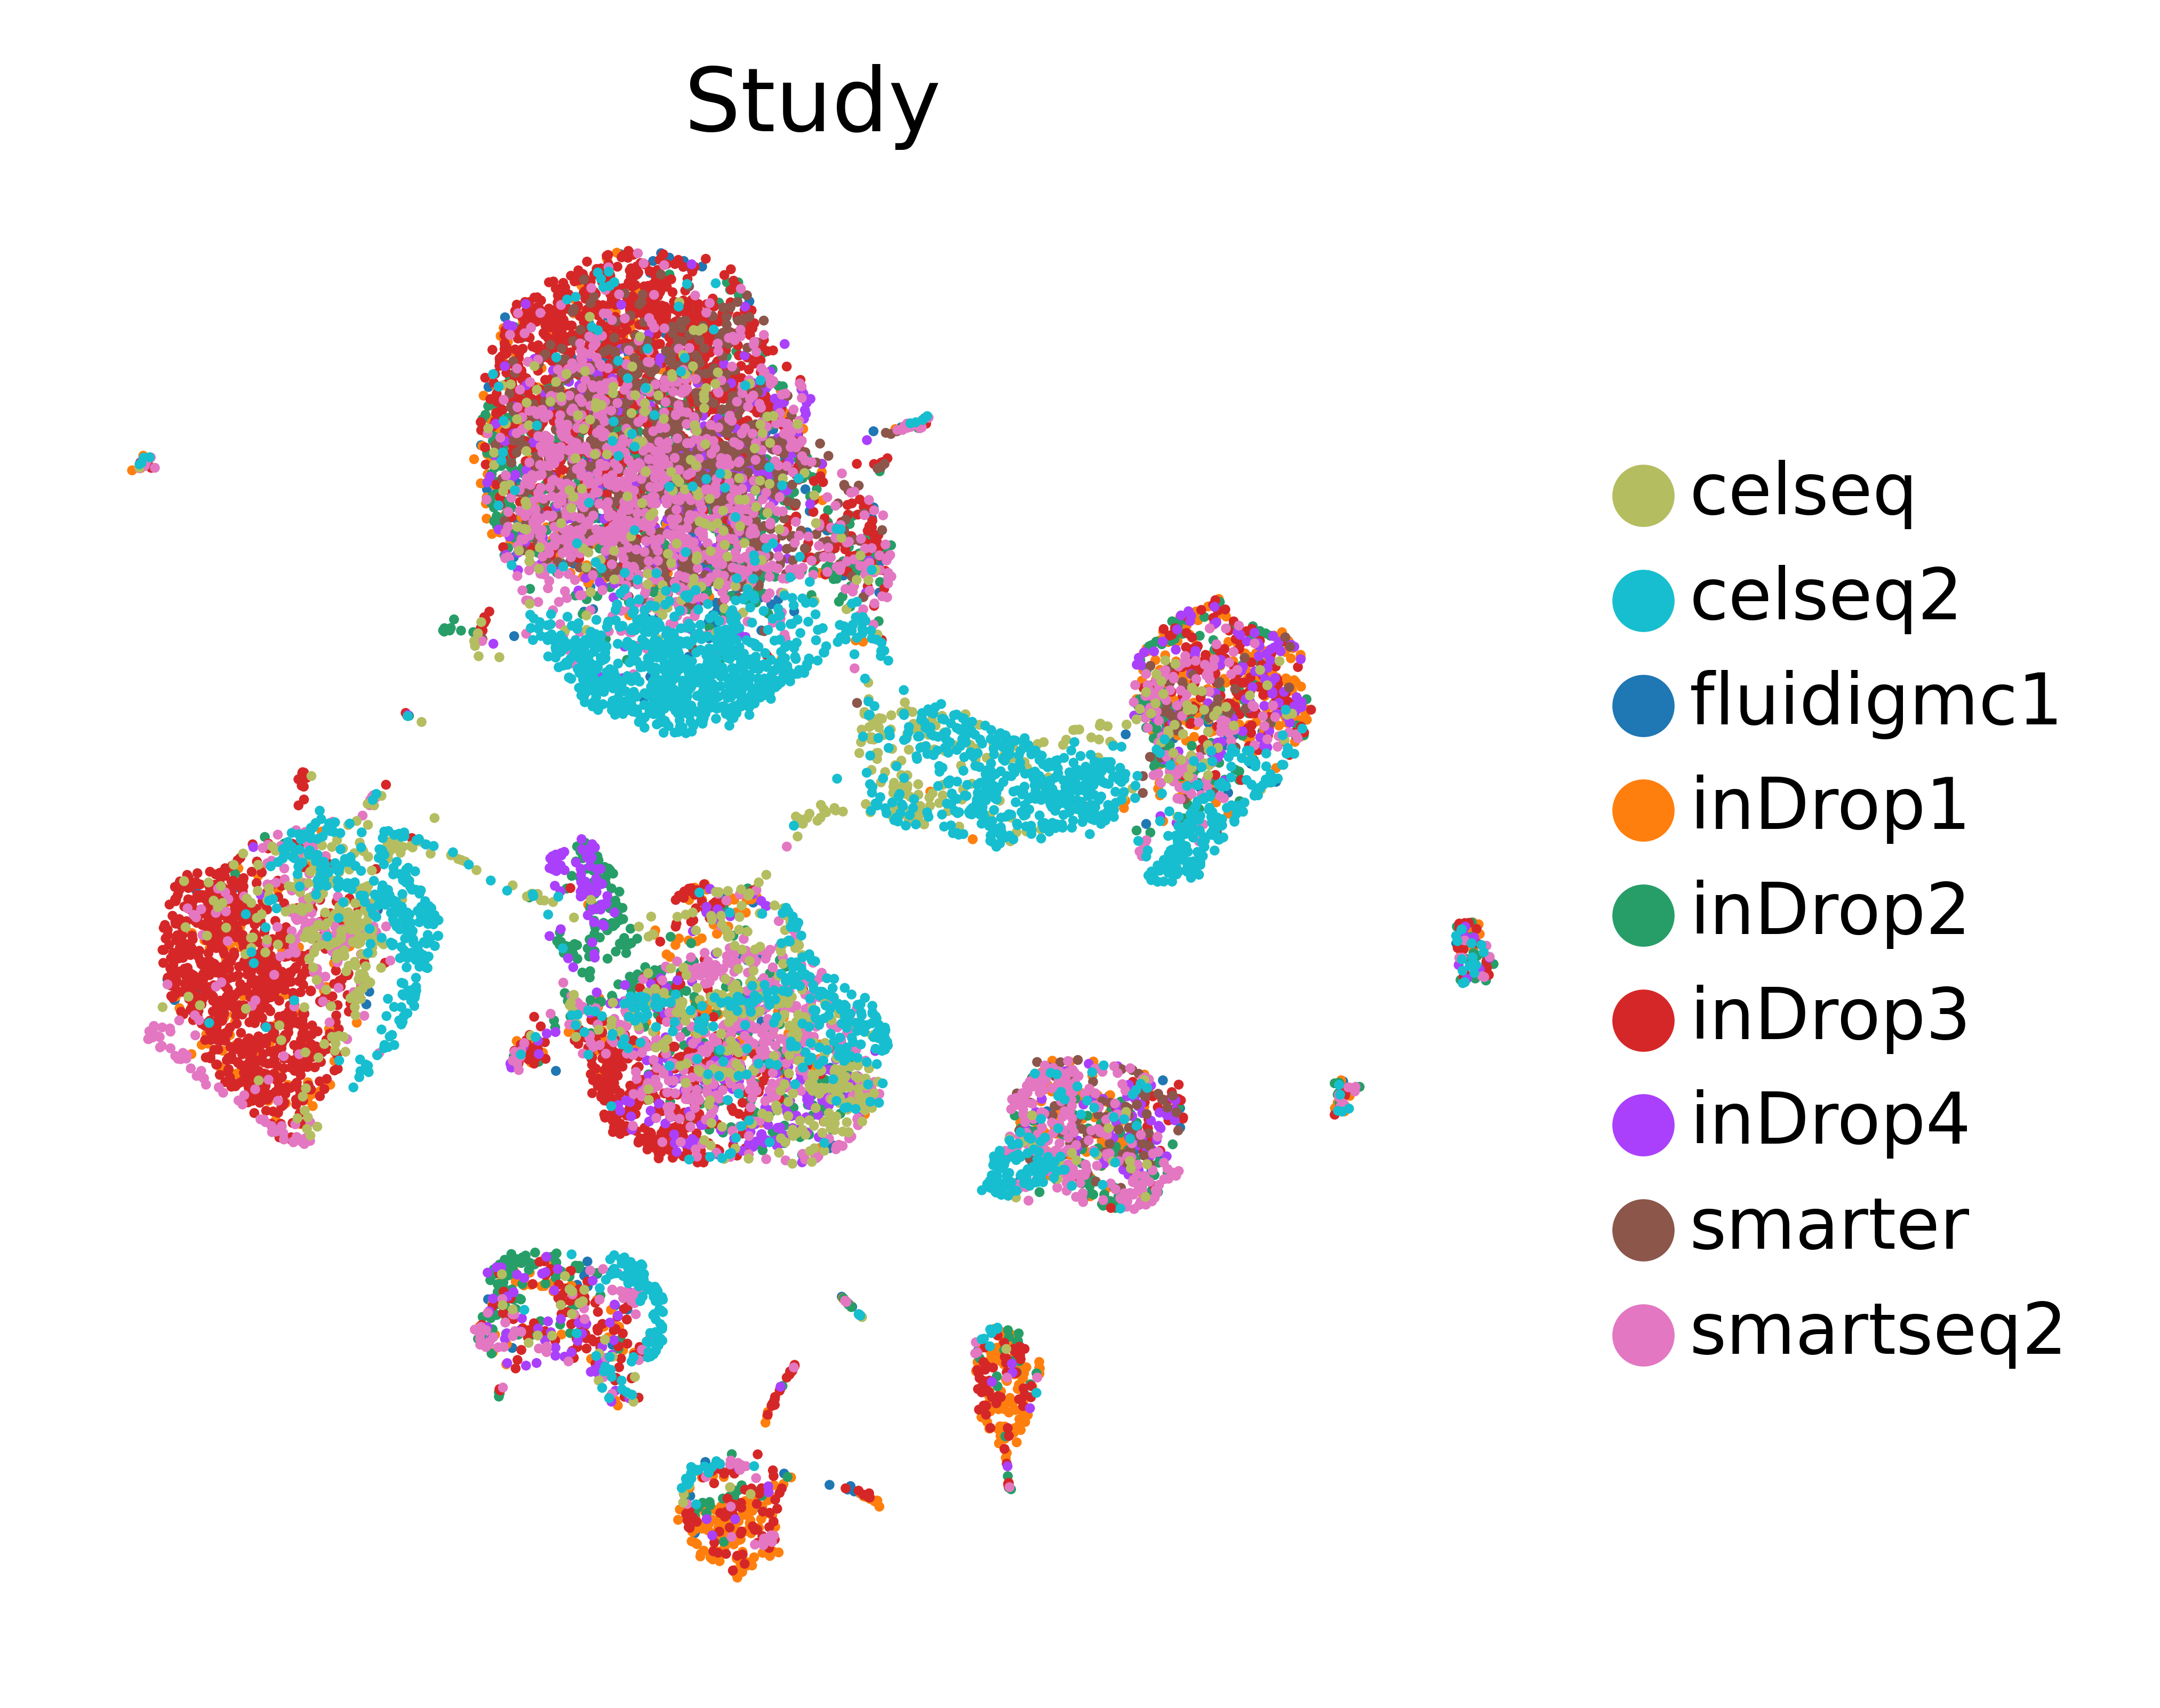

In [202]:
plt.rcParams['legend.fontsize'] = 8
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
sc.pl.umap(
    adata_latent,
    color='study',
    size=5, 
    frameon=False, 
    show=False, 
    palette=palette_study,
    ax=ax, 
    alpha=1
)
ax.set_title('Study', fontsize=10)
fig.savefig('figure1/umap_latent_wquery_study.png', dpi=600, bbox_inches='tight')

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


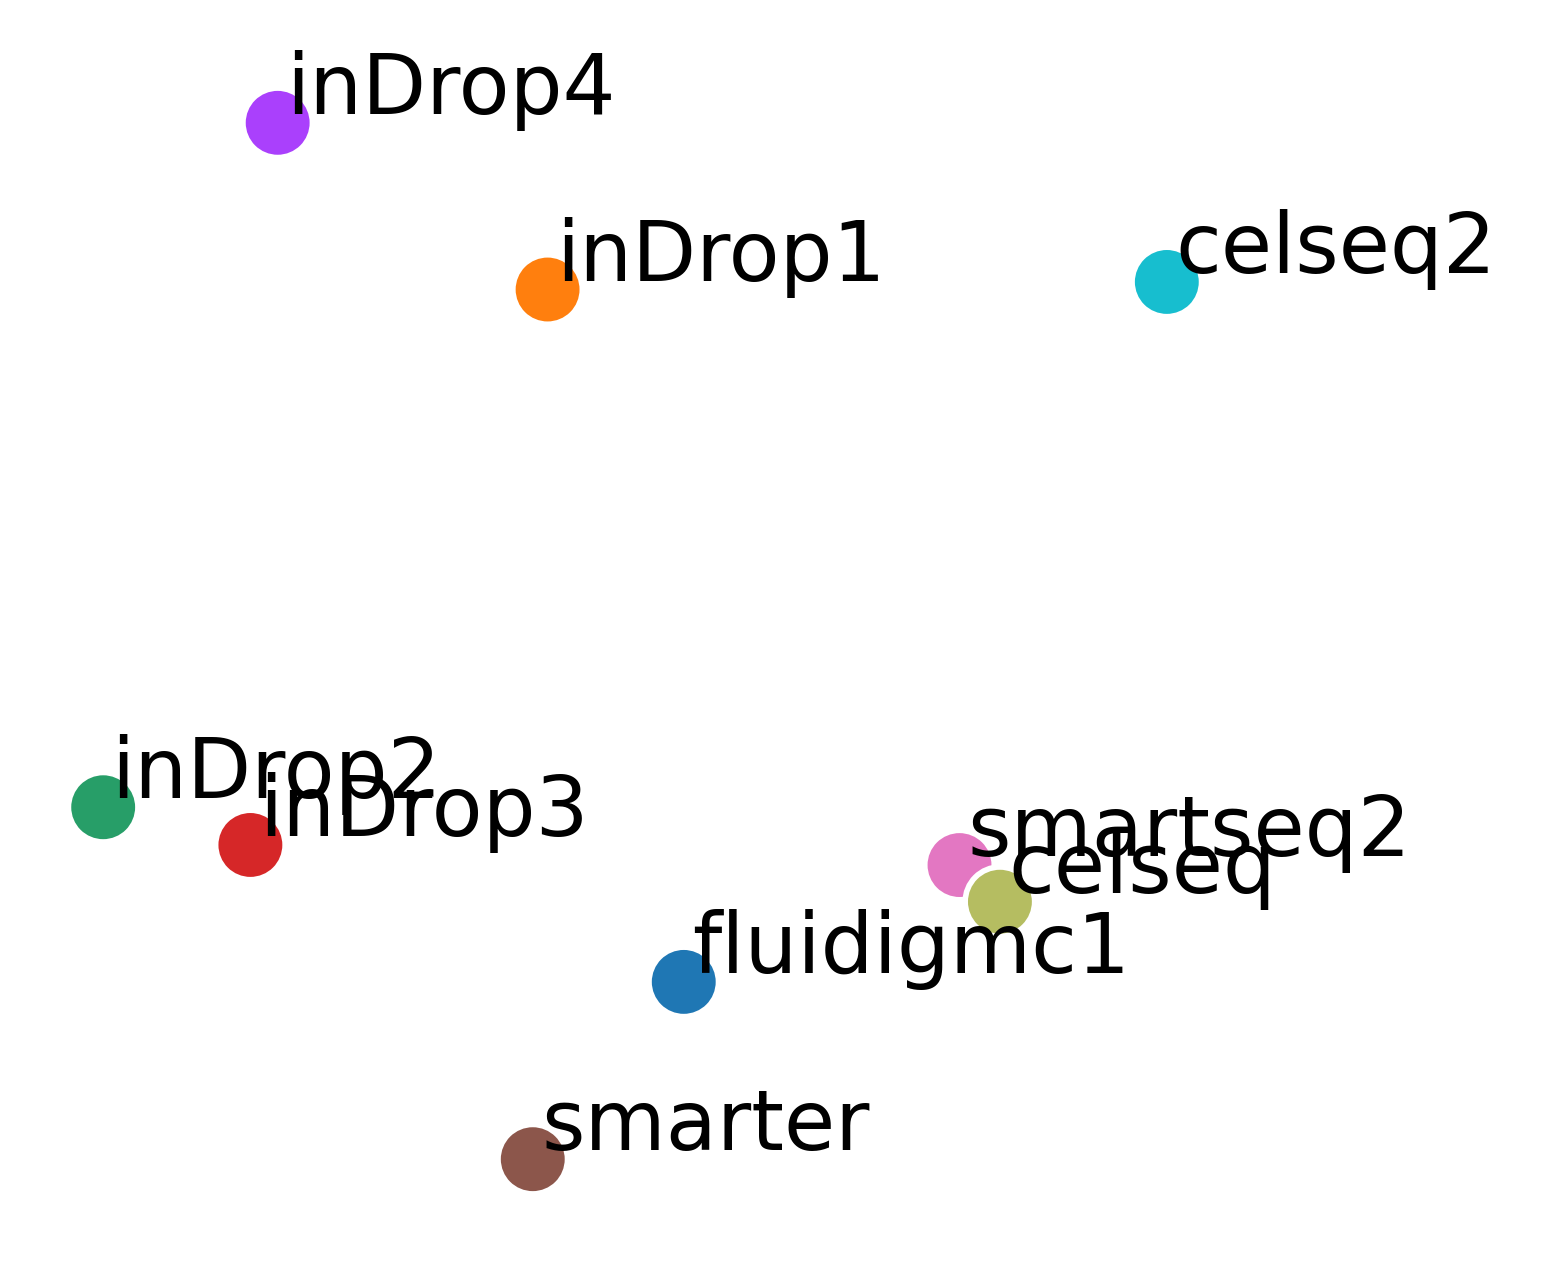

In [42]:
from sklearn.decomposition import KernelPCA


embedding = lataq.model.embedding.weight.detach().cpu().numpy()
pca = KernelPCA(n_components=5, kernel='cosine')
emb_pca = pca.fit_transform(embedding)
cond = lataq.conditions_

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
import seaborn as sns
sns.scatterplot(
    emb_pca[:, 0], 
    emb_pca[:, 1], 
    cond,
    s=100,
    hue_order=cond,
    #palette = 'Reds',
    ax=ax
)

for i in range(emb_pca.shape[0]):
    ax.text(
        x=emb_pca[i, 0]+0.01,
        y=emb_pca[i, 1]+0.01,
        s=cond[i],
        fontsize=12
    )
ax.grid(False)
ax.set_title('', fontsize=10)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
ax.get_legend().remove()
fig.savefig('figure1/study_emb.png', dpi=600, bbox_inches='tight')